# Demo workbook
This workbook is intended to organize and demonstrate the process of inferring precursor concentrations from oxidized terminal products measurements.
It has a few main steps listed here and discussed in more depth below, which will help to confirm that the inference went smoothly, or to identify what went wrong if it didn't!
### Steps to ensure happy inference:
 - Measurement selection and setup
 - Precursor inference configuration
 - Monte Carlo sampling configuration
 - Checking for convergence on solution
 - Check posterior/prior for reasonableness
 - Check posterior/prior predictive for reasonableness

### Notes
 - The code cells should be executed, in order, to make sure things to work properly.
 - Code cells will have comments indicating locations where you might want to change something.
 - If you make changes to files that this workbook uses (config, code, measurement data, etc.), you will most likely need to restart the jupyter kernel (button above) and re-run all cells for the changes to take effect.

In [1]:
import numpy as np
import pandas as pd
from src.measurements import Measurements
from src.run import sample_measurement
from src.config import Config
from src.posterior import Posterior
import warnings

warnings.filterwarnings('ignore')

## Measurement selection

In [2]:
DATAFILE = 'data/example_samples.csv' # Change this file name if you'd like to use a different data file
SAMPLE_NUMBER = 0 # Change this number if you'd like to select a different sample from the given data file
df = pd.read_csv(DATAFILE)
df.head()

,Sample,Citation,Units,config,C3,C4,C5,C6,C7,C8,...,C7MDL,C8MDL,PFOSMDL,C3err,C4err,C5err,C6err,C7err,C8err,PFOSerr
0,Chemguard C306-MS-C 2017 (FT 2),Ruyle et al. 2021a,mM,AFFF.yaml,9.11,16.92,6.77,1.39,0,NaN,...,0.0046,NaN,0.0035,0.1,0.1,0.1,0.1,0.1,0.1,0.1


The cell below will print out the measurement information as read from the data file. Ensure the values line up with what you expect!
("error" is in relative units, e.g. 0.1 is 10% error)

In [3]:
sample_name = df['Sample'][SAMPLE_NUMBER]
print('Sample ' + sample_name)
df_row = df.iloc[SAMPLE_NUMBER]
measurements = Measurements.from_row(df_row)
measurements.print()

Sample Chemguard C306-MS-C 2017 (FT 2)
PFCAs: {   'C3': Measurement(value=9.11, error=0.1, MDL=0.0054),
    'C4': Measurement(value=16.92, error=0.1, MDL=0.0033),
    'C5': Measurement(value=6.77, error=0.1, MDL=0.0011),
    'C6': Measurement(value=1.39, error=0.1, MDL=0.0015),
    'C7': Measurement(value=0, error=0.1, MDL=0.0046)}
targeted_precursors: {}
PFOS: Measurement(value=0, error=0.1, MDL=0.0035)
associated_config: 'config/AFFF.yaml'


The following cell will show the precursor inference configuration used. This is most useful for debugging problems.

In [4]:
config = Config.from_yaml(measurements.associated_config)
prior_name = config.prior_name
config.print()

Config object:
{   'ecf_relativechain_yield_errors': [0, 0.1144, 0.0089, 0, 0, 0, 0, 0],
    'ecf_relativechain_yields': [0, 0.869, 0.0085, 0, 0, 0, 0, 0],
    'ft_relativechain_yield_errors': [   0.0065,
                                         0.0721,
                                         0.0435,
                                         0.0207,
                                         0.0171,
                                         0.0252,
                                         0,
                                         0],
    'ft_relativechain_yields': [   0.0245,
                                   0.185,
                                   0.2874,
                                   0.1943,
                                   0.1425,
                                   0.0867,
                                   0,
                                   0],
    'jeffreys_variance': None,
    'possible_precursors': [   '4:2 FT',
                               '6:2 FT',
              

## Monte Carlo sampling configuration
Use this cell to change some options associated with the MCMC sampling.
 - `TARGET_EFFECTIVE_STEPS` will set the "effective sample size" that the sampler will try to achieve (higher number will run for longer).
 - `MAX_STEPS` will set a number of iterations after which the sampler will stop, regardless of whether it has reached the effective sample size target.
 - `alpha` (more advanced) is a parameter that can be changed to try to find a more efficient sampling path if you can't get convergence in a reasonable time. The recommended strategy for this parameter is to: 
   - a) not change it from its default value (0.55) unless you run into issues 
   - b) if you run into issues related to sampling efficiency, change this to `-1`. This will cause the sampler to automatically try to tune this number to a good one for  your problem 
   - c) if that also doesn't work, it's usually an indication that `alpha` is not your problem!
 

In [5]:
# Sampling options:
TARGET_EFFECTIVE_STEPS = 500 # the "effective sample size" desired, which accounts for autocorrelation in raw samples.
MAX_STEPS = 200000
alpha = 0.55#-1 # if this is a number less than zero, the sampler will tune alpha to find an efficient acceptance rate.
MAX_DEPTH = 3 # the depth of search in the alpha-tuning process; will have no effect if alpha is set > 0. Probably no need to change this.


## Monte Carlo sampling
In this cell the sampler will iterate to find a solution, updating you on its progress periodically. You can adjust how frequently it checks for convergence (`rhat` close to `1`) and high enough effective sample size (`ess` > `TARGET_EFFECTIVE_STEPS`) by changing `Nincrement`. There will be two sets of iterations, one for the prior and one for the posterior. It should end with "SAMPLE DONE" if things went well. `ess` will be `0.0` until enough iterations are done to estimate it properly, after which it should get bigger each update. If you find that `ess` is increasing very slowly, it may be a sign that your `alpha` value is too small.

In [6]:
posterior = sample_measurement(config, measurements,
                                 prior_name=prior_name,
                                 Nincrement=5000,
                                 TARGET_EFFECTIVE_STEPS=TARGET_EFFECTIVE_STEPS,
                                 MAX_STEPS=MAX_STEPS,
                                 MAX_DEPTH=MAX_DEPTH,
                                 alpha=alpha)
posterior.save('infer_out/example') # Change this to the name of a folder you want to save your output to.

Sampling prior.
After 5000 iterations, rhat: 1.172, ess: 0.0
After 10000 iterations, rhat: 1.091, ess: 0.0
After 15000 iterations, rhat: 1.055, ess: 0.0
After 20000 iterations, rhat: 1.044, ess: 51.9
After 25000 iterations, rhat: 1.043, ess: 65.4
After 30000 iterations, rhat: 1.030, ess: 77.7
After 35000 iterations, rhat: 1.025, ess: 89.3
After 40000 iterations, rhat: 1.023, ess: 96.7
After 45000 iterations, rhat: 1.022, ess: 110.2
After 50000 iterations, rhat: 1.026, ess: 116.3
After 55000 iterations, rhat: 1.016, ess: 125.4
After 60000 iterations, rhat: 1.018, ess: 139.1
After 65000 iterations, rhat: 1.018, ess: 155.6
After 70000 iterations, rhat: 1.016, ess: 165.8
After 75000 iterations, rhat: 1.012, ess: 176.3
After 80000 iterations, rhat: 1.011, ess: 187.4
After 85000 iterations, rhat: 1.010, ess: 200.8
After 90000 iterations, rhat: 1.010, ess: 207.3
After 95000 iterations, rhat: 1.010, ess: 220.6
After 100000 iterations, rhat: 1.010, ess: 223.3
After 105000 iterations, rhat: 1.01

In [7]:
posterior = Posterior.from_saved('infer_out/example') # you can load your posterior from a saved folder like this, 
                                                   # if you'd like to work with it without running all the above steps again

## Checking solution
The following table will show some stats about the amount of inferred precusors. 

Note that the "Total precursors" column is summarizing the sum of all the precursors *for each Monte Carlo sample* and is therefore not equal to the sum of the same statistics for each precursor.

In [8]:
summary = posterior.summary_table()
summary

,Statistic,4:2 FT,6:2 FT,8:2 FT,C4 ECF,C5 ECF,C6 ECF,C7 ECF,C8 ECF,Total precursors
0,Mean,3.848001,51.920826,0.005214,0.000342,0.000164,0.001229,0.000020,0.000037,111.551666
1,Geometric mean,0.006314,50.643766,0.000269,0.000185,0.000054,0.000678,0.000009,0.000019,106.413990
2,5.0th percentile,0.000003,35.758198,0.000002,0.000021,0.000002,0.000085,0.000001,0.000002,73.014476
3,25.0th percentile,0.000146,44.168072,0.000028,0.000074,0.000018,0.000263,0.000003,0.000007,90.128232
4,50.0th percentile,0.005788,50.357502,0.000263,0.000214,0.000058,0.000800,0.000009,0.000022,104.648658
5,75.0th percentile,0.293543,58.019307,0.003164,0.000477,0.000201,0.001774,0.000024,0.000049,120.610368
6,95.0th percentile,12.297784,70.790233,0.025937,0.001144,0.000786,0.003878,0.000083,0.000122,154.879133


`show_traces` should look like random wiggles. If it looks too smooth, you may need to run more iterations. If it looks like there was a jump from one set of random wiggles to another (like a step function), you may need to run more iterations.

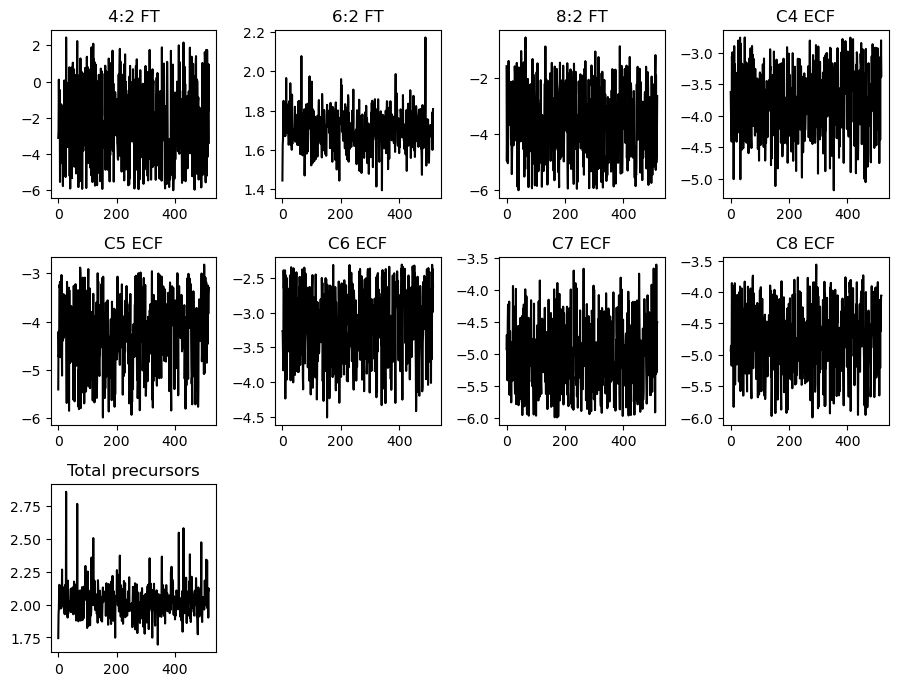

In [9]:
posterior.show_traces()

`marginalplot` will show the marginal distribution for each precursor (basically a histogram of the Monte Carlo samples) for both the posterior and the prior. What you hope to see is that the prior is broader than the posterior, which has localized around some values (since you're hoping your measurements are telling you something), and that your posterior isn't way outside what your prior indicates (this would be an indication that your prior probably doesn't match the situation).

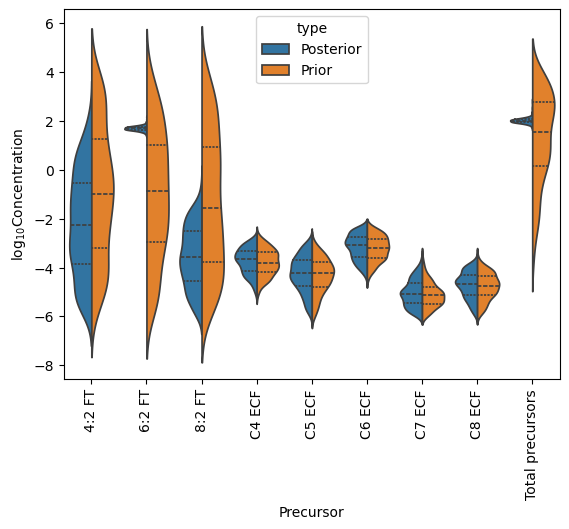

In [10]:
posterior.marginalplot()

`posterior_predictive` is a similar kind of plot, but is now showing how confidently the prior and posterior "predict" the observations. You want to see the posterior moving towards and being more concentrated around the measured values than the prior. If the measurement is outside the range of your prior, it's an indication that the situation is not what you expected (since your prior should be encoding that expectation). If your posterior is narrow and centered on the measured values, you can be more confident that you have captured the inferred behaviour well.

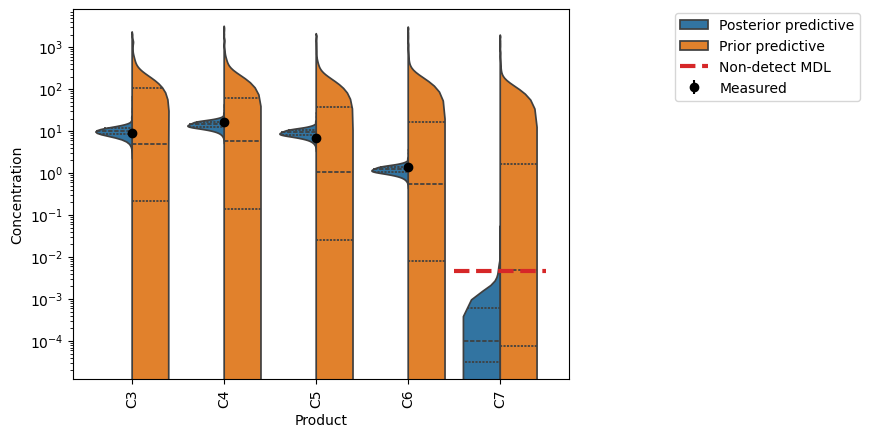

In [11]:
posterior.posterior_predictive()